In [1]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Monte Carlo Simulation of Survival Probabilities Using Direct Normal Sampling

In this method, we simulate particle trajectories where each step is sampled directly from
a Normal distribution with mean 0 and standard deviation `sigma`. We compute the survival
weight for each particle using the function G(x) and estimate the overall probability `theta`
via Monte Carlo averaging.

Two implementations are provided:
1. Loop-based: standard nested loops over particles and time steps.
2. Vectorized: fully vectorized using NumPy for efficiency.

In [2]:
# ---- Parameters ----
n = 10000      # number of particles for Monte Carlo estimate
T = 60         # number of time steps
sigma = 0.1    # step size (standard deviation)
reps = 50      # number of repetitions
n_plot = 100   # Number of particle trajectories to sample for plotting

In [3]:
# ---- Survival weight function ----
def G(x):
    """
    Survival weight function.
    Returns the weight for a particle at position x.
    """
    return np.exp(-0.5 * x**2)

# ---- Loop-based Monte Carlo simulation ----
def monte_carlo_loop(n, T, sigma, G):
    """
    Simulate n particle trajectories over T time steps using loops.

    Parameters:
        n (int): Number of particles
        T (int): Number of time steps
        sigma (float): Step size standard deviation
        G (function): Survival weight function

    Returns:
        theta (float): Monte Carlo estimate of overall survival probability
        X (np.array): Trajectories of all particles (shape: T x n)
    """
    X = np.zeros((T, n))  # Initialize particle positions
    # Simulate each particle trajectory
    for i in range(n):
        for t in range(1, T):
            # Increment position by Normal(0, sigma)
            X[t, i] = X[t-1, i] + np.random.normal(0, sigma)
    # Compute product of weights along trajectory for each particle
    P = np.array([np.prod(G(X[:, i])) for i in range(n)])
    # Monte Carlo estimate as mean over all particles
    theta = np.mean(P)
    return theta, X

# ---- Vectorized Monte Carlo simulation ----
def monte_carlo_vectorized(n, T, sigma, G):
    """
    Simulate n particle trajectories over T time steps using vectorized NumPy operations.

    Parameters:
        n (int): Number of particles
        T (int): Number of time steps
        sigma (float): Step size standard deviation
        G (function): Survival weight function

    Returns:
        theta (float): Monte Carlo estimate of overall survival probability
        X (np.array): Trajectories of all particles (shape: T x n)
    """
    # Generate all steps at once: shape (T-1, n)
    steps = np.random.normal(0, sigma, size=(T-1, n))
    # Compute cumulative sum along time axis and prepend initial positions (0)
    X = np.vstack([np.zeros(n), np.cumsum(steps, axis=0)])
    # Compute product of weights along trajectory for each particle
    P = np.prod(G(X), axis=0)
    # Monte Carlo estimate
    theta = np.mean(P)
    return theta, X

# ---- Storage for results ----
results = []

# ---- RUN SIMULATIONS ----
for r in range(reps):
    # Loop version
    start = time.time()
    theta_loop, X_loop = monte_carlo_loop(n, T, sigma, G)
    end = time.time()
    results.append({'Method': 'Loop', 'Theta': theta_loop, 'Time(s)': end-start})

    # Vectorized version
    start = time.time()
    theta_vec, X_vec = monte_carlo_vectorized(n, T, sigma, G)
    end = time.time()
    results.append({'Method': 'Vectorized', 'Theta': theta_vec, 'Time(s)': end-start})

# ---- Convert results to DataFrame ----
df_results = pd.DataFrame(results)

# ---- Summary statistics ----
summary = df_results.groupby('Method').agg({
    'Theta': ['mean', 'std'],
    'Time(s)': ['mean', 'std']
}).reset_index()

print("\nDetailed results for each repetition:")
print(df_results)
print("\nSummary statistics:")
print(summary)


Detailed results for each repetition:
        Method     Theta   Time(s)
0         Loop  0.073175  0.467545
1   Vectorized  0.072090  0.016036
2         Loop  0.072848  0.467605
3   Vectorized  0.071674  0.016997
4         Loop  0.073413  0.467633
..         ...       ...       ...
95  Vectorized  0.072382  0.019577
96        Loop  0.071342  0.533628
97  Vectorized  0.073254  0.017819
98        Loop  0.071529  0.530788
99  Vectorized  0.071126  0.019619

[100 rows x 3 columns]

Summary statistics:
       Method     Theta             Time(s)          
                   mean       std      mean       std
0        Loop  0.072311  0.001218  0.489510  0.037600
1  Vectorized  0.072067  0.001161  0.015747  0.001722


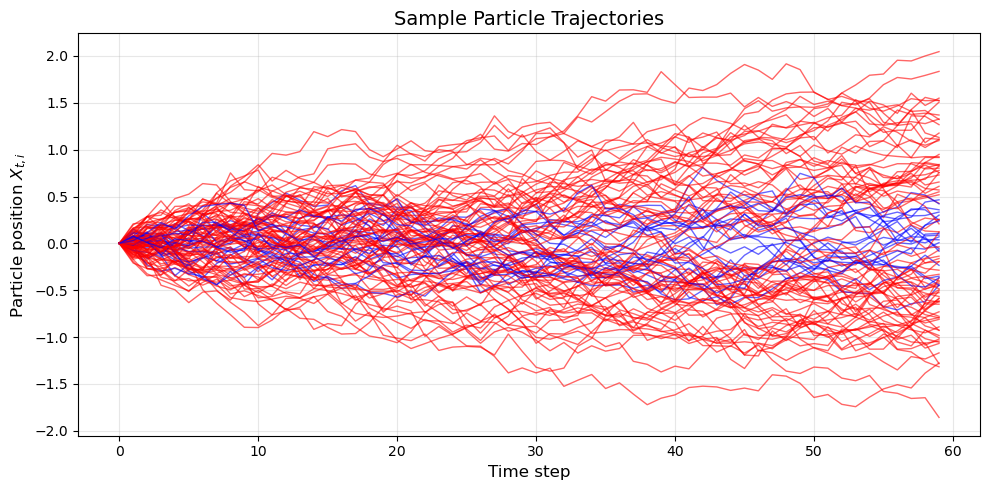

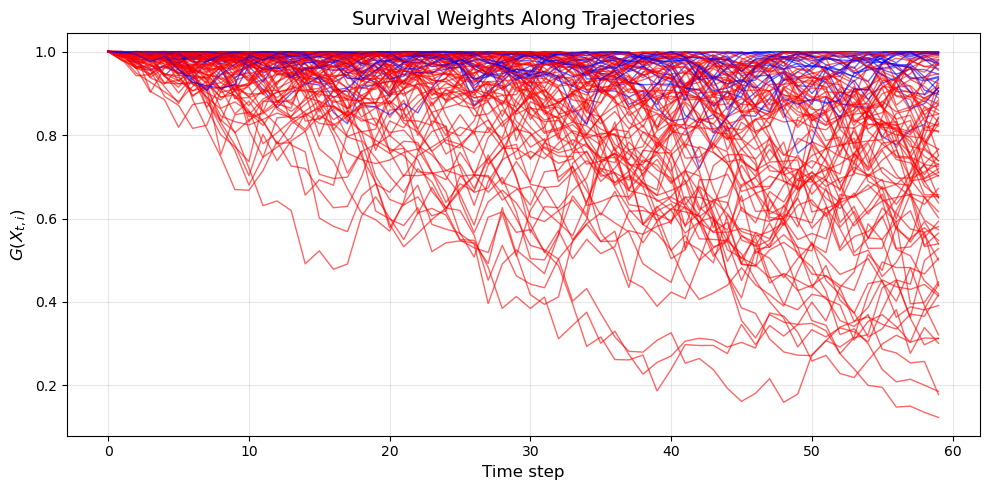

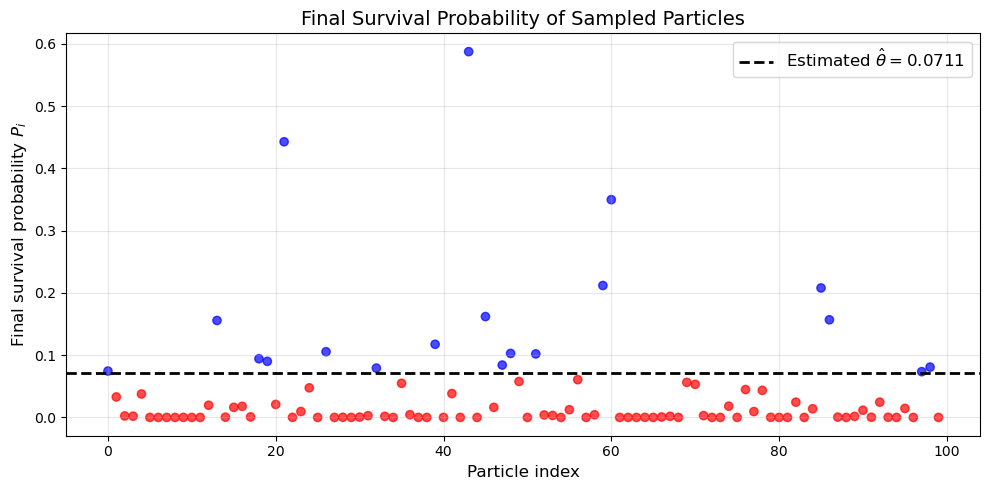

In [4]:
# ---- Sample indices ----
# Randomly select n_plot particles without replacement for visualization
sample_indices = np.random.choice(n, n_plot, replace=False)

# ---- Sample trajectories ----
X_sample = X_vec[:, sample_indices]          # Extract positions of sampled particles
G_sample = G(X_sample)                       # Compute survival weights for sampled particles
P_sample = np.prod(G_sample, axis=0)        # Final survival probability for each sampled particle
theta_hat = np.mean(np.prod(G(X_vec), axis=0))  # Estimated overall survival probability from all particles

# ---- Determine colors based on final survival probability ----
# Particles with P_i >= theta_hat are blue, others are red
colors = ['blue' if p >= theta_hat else 'red' for p in P_sample]

# ---- Plot 1: Particle positions ----
plt.figure(figsize=(10,5))
for i in range(n_plot):
    plt.plot(X_sample[:, i], color=colors[i], alpha=0.6, linewidth=1)
plt.xlabel('Time step', fontsize=12)
plt.ylabel('Particle position $X_{t,i}$', fontsize=12)
plt.title('Sample Particle Trajectories', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()  # Show plot directly

# ---- Plot 2: G(position) ----
plt.figure(figsize=(10,5))
for i in range(n_plot):
    plt.plot(G_sample[:, i], color=colors[i], alpha=0.6, linewidth=1)
plt.xlabel('Time step', fontsize=12)
plt.ylabel('$G(X_{t,i})$', fontsize=12)
plt.title('Survival Weights Along Trajectories', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()  # Show plot directly

# ---- Plot 3: Final survival probability ----
plt.figure(figsize=(10,5))
plt.scatter(range(n_plot), P_sample, color=colors, alpha=0.7)
plt.axhline(theta_hat, color='black', linestyle='--', linewidth=2,
            label=f'Estimated $\\hat{{\\theta}} = {theta_hat:.4f}$')
plt.xlabel('Particle index', fontsize=12)
plt.ylabel('Final survival probability $P_i$', fontsize=12)
plt.title('Final Survival Probability of Sampled Particles', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()  # Show plot directly

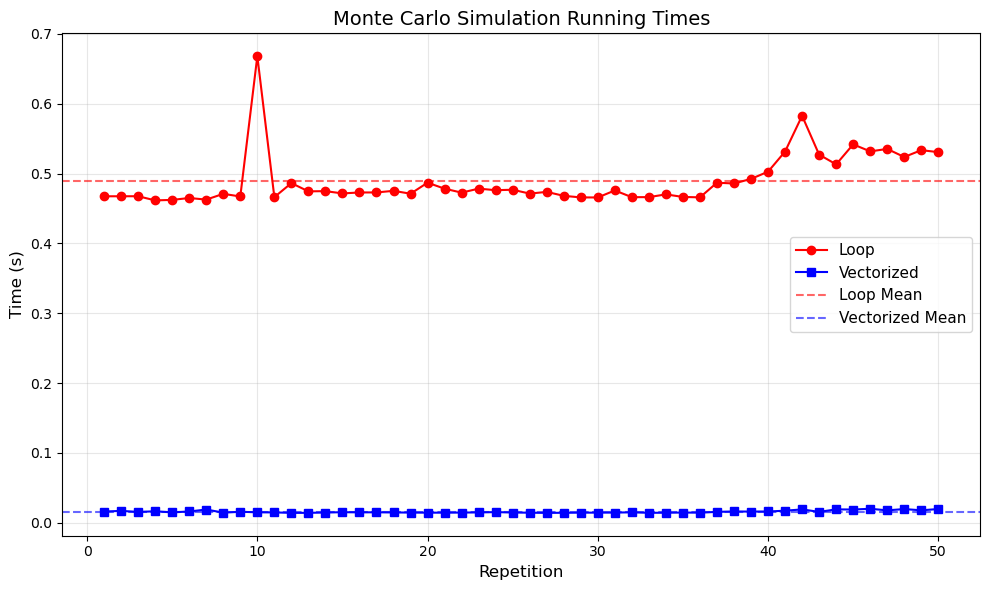

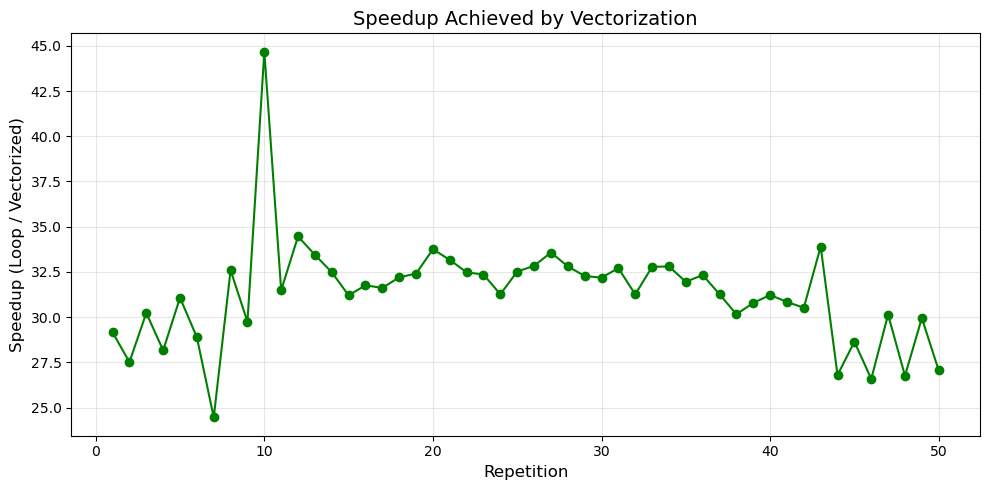

Average speedup: 31.30×


In [5]:
# ---- Prepare data ----
# Extract running times for each method
loop_times = df_results[df_results['Method'] == 'Loop']['Time(s)']
vec_times  = df_results[df_results['Method'] == 'Vectorized']['Time(s)']

# ---- Plot 1: Running times ----
plt.figure(figsize=(10,6))
# Plot Loop times with 'o-' marker
plt.plot(range(1, len(loop_times)+1), loop_times, 'o-', color='red', label='Loop')
# Plot Vectorized times with 's-' marker
plt.plot(range(1, len(vec_times)+1), vec_times, 's-', color='blue', label='Vectorized')
# Horizontal dashed lines for average times
plt.axhline(loop_times.mean(), color='red', linestyle='--', alpha=0.6, label='Loop Mean')
plt.axhline(vec_times.mean(), color='blue', linestyle='--', alpha=0.6, label='Vectorized Mean')
plt.xlabel('Repetition', fontsize=12)
plt.ylabel('Time (s)', fontsize=12)
plt.title('Monte Carlo Simulation Running Times', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()  # Show the plot directly

# ---- Plot 2: Speedup ----
# Compute speedup as ratio of Loop time to Vectorized time
speedup = loop_times.values / vec_times.values

plt.figure(figsize=(10,5))
plt.plot(range(1, len(speedup)+1), speedup, 'o-', color='green')
plt.xlabel('Repetition', fontsize=12)
plt.ylabel('Speedup (Loop / Vectorized)', fontsize=12)
plt.title('Speedup Achieved by Vectorization', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()  # Show the plot directly

# ---- Print average speedup ----
print(f"Average speedup: {speedup.mean():.2f}×")

### Monte Carlo Simulation Using Uniform-to-Normal Transformation

In this algorithm, we generate standard normal random variables by transforming
uniform random variables using the Box–Muller method. The simulation estimates
the expected product of survival weights G(X) over particle trajectories.

- Loop-based and vectorized implementations are provided.
- The Box–Muller transform converts U(0,1) random numbers to standard normal.
- Survival weight function G(x) = exp(-0.5 * x^2).

In [6]:
# ---- Survival weight function ----
def G(x):
    """
    Compute survival weight for particle positions.

    Parameters:
        x : np.array
            Array of particle positions

    Returns:
        weights : np.array
            Survival weights G(x) = exp(-0.5 * x^2)
    """
    return np.exp(-0.5 * x**2)

# ---- Loop-based Monte Carlo simulation using Uniform -> Normal ----
def monte_carlo_loop_uniform(n, T, sigma, G):
    """
    Monte Carlo estimate using a loop and Box–Muller transformation.

    Parameters:
        n : int
            Number of particles
        T : int
            Number of time steps
        sigma : float
            Step size for normal increments
        G : function
            Survival weight function

    Returns:
        theta : float
            Estimated expectation of product of weights
        X : np.array
            Trajectories of all particles
    """
    X = np.zeros((T, n))  # Initialize particle positions
    for i in range(n):
        for t in range(1, T):
            # Generate two independent U(0,1) random numbers
            U1, U2 = np.random.rand(2)
            # Transform uniform numbers to standard normal (Box–Muller)
            Z = np.sqrt(-2 * np.log(U1)) * np.cos(2 * np.pi * U2)
            # Update particle position with scaled normal increment
            X[t, i] = X[t-1, i] + sigma * Z

    # Compute product of survival weights for each particle
    P = np.array([np.prod(G(X[:, i])) for i in range(n)])
    theta = np.mean(P)  # Monte Carlo estimate
    return theta, X

# ---- Vectorized Monte Carlo simulation using Uniform -> Normal ----
def monte_carlo_vectorized_uniform(n, T, sigma, G):
    """
    Vectorized Monte Carlo estimate using Box–Muller transform.

    Parameters:
        n : int
            Number of particles
        T : int
            Number of time steps
        sigma : float
            Step size for normal increments
        G : function
            Survival weight function

    Returns:
        theta : float
            Estimated expectation of product of weights
        X : np.array
            Trajectories of all particles
    """
    # Generate uniform random numbers for all particles and time steps
    U1 = np.random.rand(T-1, n)
    U2 = np.random.rand(T-1, n)

    # Box–Muller transform to standard normal
    Z = np.sqrt(-2 * np.log(U1)) * np.cos(2 * np.pi * U2)

    # Scale increments and build particle trajectories
    steps = sigma * Z
    X = np.vstack([np.zeros(n), np.cumsum(steps, axis=0)])

    # Compute product of survival weights along each trajectory
    P = np.prod(G(X), axis=0)
    theta = np.mean(P)  # Monte Carlo estimate
    return theta, X

# ---- Storage for results ----
results = []

# ---- Run multiple repetitions ----
for r in range(reps):
    # Loop-based version
    start = time.time()
    theta_loop, X_loop = monte_carlo_loop_uniform(n, T, sigma, G)
    end = time.time()
    results.append({'Method': 'Loop', 'Theta': theta_loop, 'Time(s)': end-start})

    # Vectorized version
    start = time.time()
    theta_vec, X_vec = monte_carlo_vectorized_uniform(n, T, sigma, G)
    end = time.time()
    results.append({'Method': 'Vectorized', 'Theta': theta_vec, 'Time(s)': end-start})

# ---- Convert results to DataFrame ----
df_results = pd.DataFrame(results)

# ---- Summary statistics ----
summary = df_results.groupby('Method').agg({
    'Theta': ['mean', 'std'],
    'Time(s)': ['mean', 'std']
}).reset_index()

# ---- Display results ----
print("\nDetailed results for each repetition:")
print(df_results)
print("\nSummary statistics:")
print(summary)


Detailed results for each repetition:
        Method     Theta   Time(s)
0         Loop  0.073201  2.060557
1   Vectorized  0.071790  0.030140
2         Loop  0.072405  2.049793
3   Vectorized  0.073791  0.027616
4         Loop  0.071151  2.092893
..         ...       ...       ...
95  Vectorized  0.072785  0.021923
96        Loop  0.073667  1.784405
97  Vectorized  0.070414  0.021952
98        Loop  0.071930  1.799946
99  Vectorized  0.071470  0.023374

[100 rows x 3 columns]

Summary statistics:
       Method     Theta             Time(s)          
                   mean       std      mean       std
0        Loop  0.072677  0.001062  1.835796  0.074445
1  Vectorized  0.072458  0.001133  0.023510  0.002628


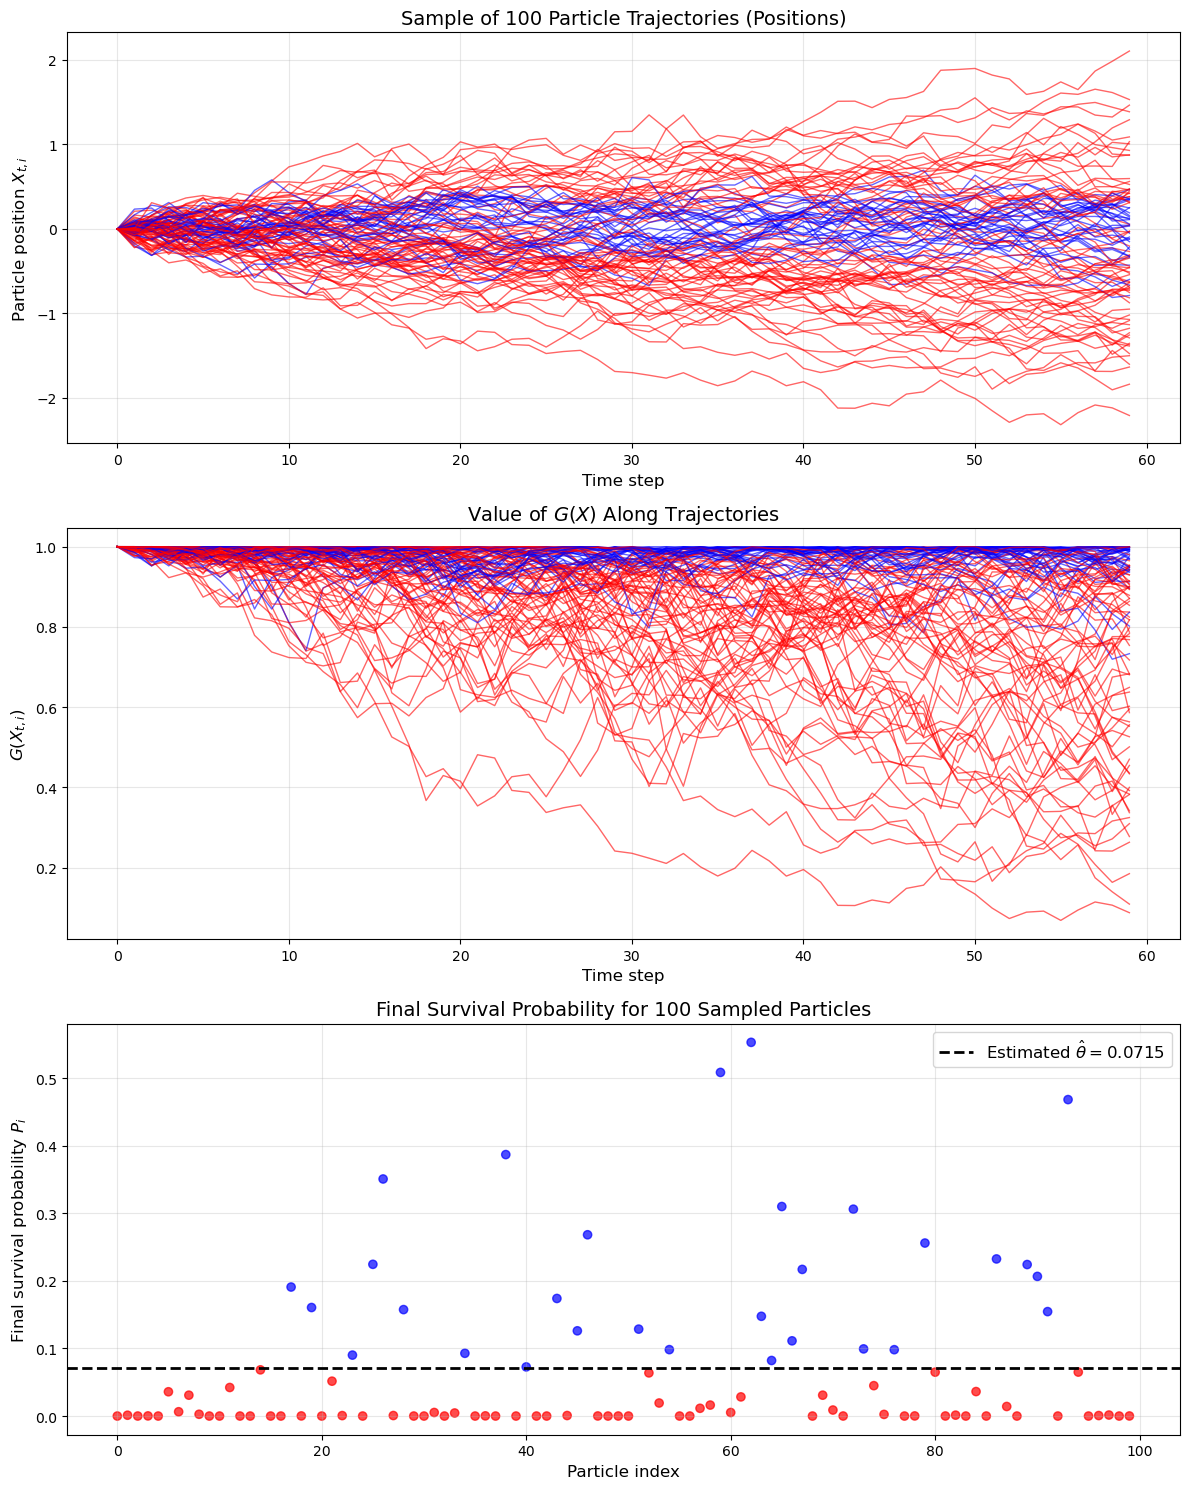

In [7]:
# ---- Sample indices ----
# Randomly select 'n_plot' particles without replacement for visualization
sample_indices = np.random.choice(n, n_plot, replace=False)

# ---- Sample trajectories ----
X_sample = X_vec[:, sample_indices]          # Positions of sampled particles over time
G_sample = G(X_sample)                       # Compute survival weights G(X) for sampled trajectories
P_sample = np.prod(G_sample, axis=0)        # Final survival probability for each sampled particle
theta_hat = np.mean(np.prod(G(X_vec), axis=0))  # Monte Carlo estimate of theta using all particles

# ---- Determine colors based on final survival probability ----
# Color particles blue if their survival probability >= estimated theta, else red
colors = ['blue' if p >= theta_hat else 'red' for p in P_sample]

# ---- Create figure with 3 vertically stacked subplots ----
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# --- Plot 1: Particle positions ---
# Visualize trajectories of sampled particles
for i in range(n_plot):
    axes[0].plot(X_sample[:, i], color=colors[i], alpha=0.6, linewidth=1)
axes[0].set_xlabel('Time step', fontsize=12)
axes[0].set_ylabel('Particle position $X_{t,i}$', fontsize=12)
axes[0].set_title(f'Sample of {n_plot} Particle Trajectories (Positions)', fontsize=14)
axes[0].grid(True, alpha=0.3)

# --- Plot 2: G(position) ---
# Plot the survival weights G(X) along each trajectory
for i in range(n_plot):
    axes[1].plot(G_sample[:, i], color=colors[i], alpha=0.6, linewidth=1)
axes[1].set_xlabel('Time step', fontsize=12)
axes[1].set_ylabel('$G(X_{t,i})$', fontsize=12)
axes[1].set_title(f'Value of $G(X)$ Along Trajectories', fontsize=14)
axes[1].grid(True, alpha=0.3)

# --- Plot 3: Final survival probability ---
# Scatter plot of final survival probability P_i for sampled particles
axes[2].scatter(range(n_plot), P_sample, color=colors, alpha=0.7)
# Draw horizontal line at estimated theta
axes[2].axhline(theta_hat, color='black', linestyle='--', linewidth=2,
                label=f'Estimated $\\hat{{\\theta}} = {theta_hat:.4f}$')
axes[2].set_xlabel('Particle index', fontsize=12)
axes[2].set_ylabel('Final survival probability $P_i$', fontsize=12)
axes[2].set_title(f'Final Survival Probability for {n_plot} Sampled Particles', fontsize=14)
axes[2].legend(fontsize=12)
axes[2].grid(True, alpha=0.3)

# ---- Adjust layout and display plots ----
plt.tight_layout()
plt.show()

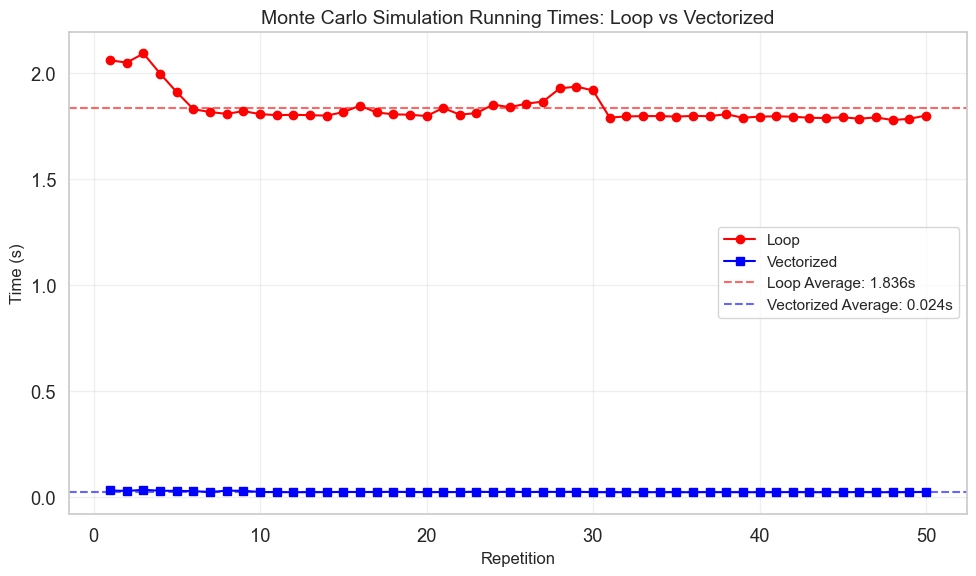

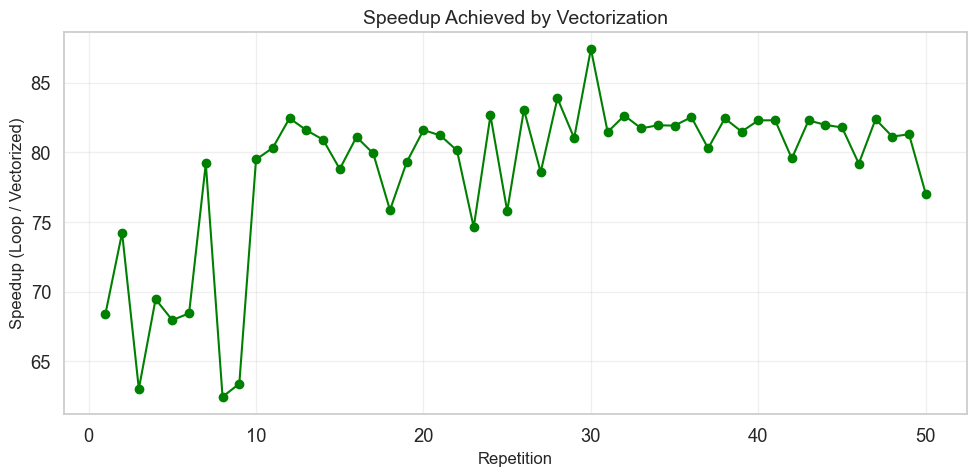

Average speedup: 78.67×


In [8]:
# ---- Set Seaborn style for plots ----
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

# ---- Extract running times for each method from DataFrame ----
loop_times = df_results[df_results['Method'] == 'Loop']['Time(s)']         # Loop-based Monte Carlo times
vec_times  = df_results[df_results['Method'] == 'Vectorized']['Time(s)']   # Vectorized Monte Carlo times

# ---- Plot 1: Running times per repetition ----
plt.figure(figsize=(10,6))

# Plot running times with markers
plt.plot(range(1, len(loop_times)+1), loop_times, 'o-', color='red', label='Loop')          # Loop
plt.plot(range(1, len(vec_times)+1), vec_times, 's-', color='blue', label='Vectorized')    # Vectorized

# Draw horizontal lines for average times
plt.axhline(loop_times.mean(), color='red', linestyle='--', alpha=0.6,
            label=f'Loop Average: {loop_times.mean():.3f}s')
plt.axhline(vec_times.mean(), color='blue', linestyle='--', alpha=0.6,
            label=f'Vectorized Average: {vec_times.mean():.3f}s')

# Labels, title, legend, and grid
plt.xlabel('Repetition', fontsize=12)
plt.ylabel('Time (s)', fontsize=12)
plt.title('Monte Carlo Simulation Running Times: Loop vs Vectorized', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---- Compute speedup ----
# Speedup = time of Loop / time of Vectorized
speedup = loop_times.values / vec_times.values

# ---- Plot 2: Speedup per repetition ----
plt.figure(figsize=(10,5))
plt.plot(range(1, len(speedup)+1), speedup, 'o-', color='green')
plt.xlabel('Repetition', fontsize=12)
plt.ylabel('Speedup (Loop / Vectorized)', fontsize=12)
plt.title('Speedup Achieved by Vectorization', fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ---- Print average speedup across repetitions ----
print(f"Average speedup: {speedup.mean():.2f}×")